In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sstcam_simulation import Camera, SSTCameraMapping, PhotoelectronSource
from sstcam_simulation.plotting import CameraImage
camera = Camera(
    mapping=SSTCameraMapping(n_pixels=8),
    digital_trigger_length=60,
)
pe = PhotoelectronSource(camera=camera, seed=1).get_uniform_illumination(time=100, illumination=1, laser_pulse_width=3)
pe.time[5:] += 50

# Tutorial 7: NNSuperpixelAboveThreshold

This tutorial demonstrates the stages in the default `Trigger` logic. The methods described in this tutorial do not need to be called manually (they are called within `EventAcquisition.get_trigger`). However, they may be useful in particular investigations (e.g. in tutorial 4_bias_scan)

In [3]:
from sstcam_simulation.event.trigger import NNSuperpixelAboveThreshold
trigger = NNSuperpixelAboveThreshold(camera=camera)
NNSuperpixelAboveThreshold?

Init signature: NNSuperpixelAboveThreshold(camera)
Docstring:     
Triggers are created when two neighbouring superpixels are above a
threshold (within a coincidence window)
Init docstring:
Base for classes which define the trigger logic for the camera.
Subclasses should define the __call__ method to return the
trigger times.
File:           ~/Software/sstcam-simulation/sstcam_simulation/event/trigger.py
Type:           ABCMeta
Subclasses:     


## Continuous readout

Obtain a `continuous_readout` for this demonstration

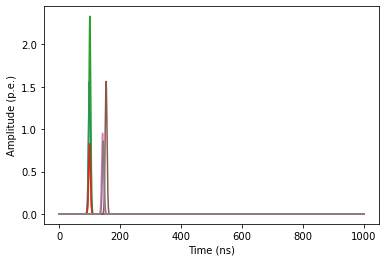

In [4]:
from sstcam_simulation.event.acquisition import EventAcquisition
acquisition = EventAcquisition(camera=camera, seed=1)
readout = acquisition.get_continuous_readout(pe)
# Divide by peak_height to convert sample units to photoelectrons
plt.plot(camera.continuous_readout_time_axis, readout.T / camera.reference_pulse.peak_height)
plt.xlabel("Time (ns)")
_ = plt.ylabel("Amplitude (p.e.)")

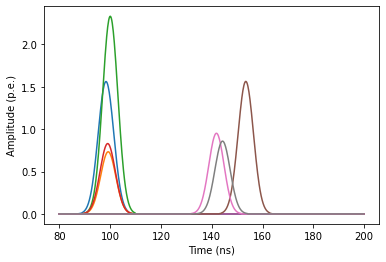

In [5]:
plt.plot(camera.continuous_readout_time_axis[400:1000], readout[:, 400:1000].T / camera.reference_pulse.peak_height)
plt.xlabel("Time (ns)")
_ = plt.ylabel("Amplitude (p.e.)")

## Superpixel Digital Trigger Line

The continuous readout from each pixel is continuously summed with the readout from the other pixels of the same superpixel. This summed readout is then compared with the trigger threshold, to produce a boolean array. 

To account for the coincidence window (for the backplane trigger between neighbouring superpixels, simulated later) X ns are padded to each True reading. This is performed by `extend_by_coincidence_window`.

In [6]:
trigger.get_superpixel_digital_trigger_line?

Signature: trigger.get_superpixel_digital_trigger_line(continuous_readout)
Docstring:
Obtain the boolean digital trigger line for each superpixel, based on
if the continuous readout (summed across each superpixel) crosses the
trigger threshold

Parameters
----------
continuous_readout : ndarray
    Array emulating continuous readout from the camera
    Shape: (n_pixels, n_continuous_readout_samples)

Returns
-------
digital_trigger : ndarray
    Boolean array indicating where each superpixel line is "high" (True)
    Shape: (n_superpixels, n_continuous_readout_samples)
File:      ~/Software/sstcam-simulation/sstcam_simulation/event/trigger.py
Type:      method


In [7]:
camera.update_trigger_threshold(3)
digital = trigger.get_superpixel_digital_trigger_line(readout)
digital_coincidence = trigger.extend_by_digital_trigger_length(digital)

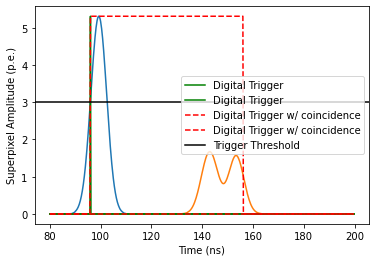

In [8]:
from sstcam_simulation.event.trigger import sum_superpixels
superpixel_sum = sum_superpixels(readout, camera.mapping.pixel_to_superpixel, camera.mapping.n_superpixels) / camera.reference_pulse.peak_height
plt.plot(camera.continuous_readout_time_axis[400:1000], superpixel_sum[:, 400:1000].T )
plt.plot(camera.continuous_readout_time_axis[400:1000], digital[:, 400:1000].T * superpixel_sum.max(), 'g-', label="Digital Trigger")
plt.plot(camera.continuous_readout_time_axis[400:1000], digital_coincidence[:, 400:1000].T * superpixel_sum.max(), 'r--', label="Digital Trigger w/ coincidence")
plt.axhline(camera.trigger_threshold, color='black', label='Trigger Threshold')
plt.xlabel("Time (ns)")
plt.ylabel("Superpixel Amplitude (p.e.)")
_ = plt.legend(loc='best')

In [9]:
print("Number of triggers per superpixel: ", trigger.get_n_superpixel_triggers(digital))

Number of triggers per superpixel:  [1 0]


## Backplane Trigger

If two neighbouring superpixels are high, within the coincidence window length, then a backplane trigger is generated. The time of the trigger occurs on the rising edge of the coincidence (bitwise AND), with the digital trigger sampled every nanosecond.

In [10]:
trigger.get_backplane_trigger?

Signature: trigger.get_backplane_trigger(digital_trigger_line, return_pairs=False)
Docstring:
Get the triggers generated on the backplane by looking for coincidences
in the digital trigger line from neighbouring superpixels

Parameters
----------
digital_trigger_line : ndarray
    Boolean array indicating where each superpixel line is "high" (True)
    Shape: (n_superpixels, n_continuous_readout_samples)
return_pairs : bool
    In addition to the default returns, include the ndarray indicating
    the superpixel pairs that caused the trigger

Returns
-------
trigger_time : ndarray
    Time of coincident rising edges between neighbouring superpixels (ns)
    Shape: (n_triggers)
trigger_pair : ndarray
    OPTIONAL (return_pairs)
    The two neighbouring superpixels with coincident digital trigger readouts
    Shape: (n_triggers, 2)
File:      ~/Software/sstcam-simulation/sstcam_simulation/event/trigger.py
Type:      method


N Backplane Triggers:  0


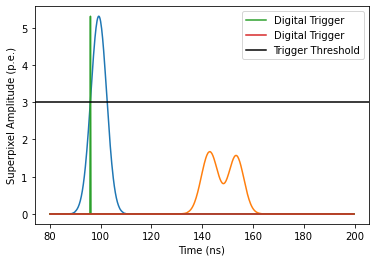

In [11]:
camera.update_trigger_threshold(3)
digital = trigger.get_superpixel_digital_trigger_line(readout)
backplane_triggers = trigger.get_backplane_trigger(digital)

superpixel_sum = sum_superpixels(readout, camera.mapping.pixel_to_superpixel, camera.mapping.n_superpixels) / camera.reference_pulse.peak_height
plt.plot(camera.continuous_readout_time_axis[400:1000], superpixel_sum[:, 400:1000].T )
plt.plot(camera.continuous_readout_time_axis[400:1000], digital[:, 400:1000].T * superpixel_sum.max(), '-', label="Digital Trigger")
plt.axhline(camera.trigger_threshold, color='black', label='Trigger Threshold')
plt.xlabel("Time (ns)")
plt.ylabel("Superpixel Amplitude (p.e.)")
_ = plt.legend(loc='best')

print("N Backplane Triggers: ", backplane_triggers.size)

N Backplane Triggers:  0


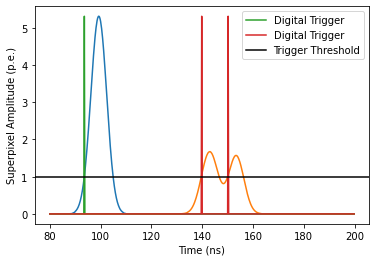

In [12]:
camera.update_trigger_threshold(1)
digital = trigger.get_superpixel_digital_trigger_line(readout)
backplane_triggers = trigger.get_backplane_trigger(digital)

superpixel_sum = sum_superpixels(readout, camera.mapping.pixel_to_superpixel, camera.mapping.n_superpixels) / camera.reference_pulse.peak_height
plt.plot(camera.continuous_readout_time_axis[400:1000], superpixel_sum[:, 400:1000].T )
plt.plot(camera.continuous_readout_time_axis[400:1000], digital[:, 400:1000].T * superpixel_sum.max(), '-', label="Digital Trigger")
plt.axhline(camera.trigger_threshold, color='black', label='Trigger Threshold')
plt.xlabel("Time (ns)")
plt.ylabel("Superpixel Amplitude (p.e.)")
_ = plt.legend(loc='best')

print("N Backplane Triggers: ", backplane_triggers.size)

N Backplane Triggers:  1


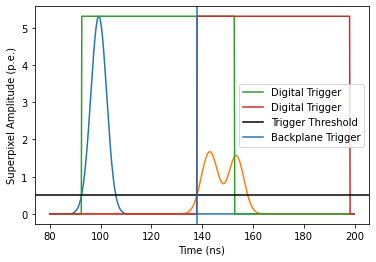

In [13]:
camera.update_trigger_threshold(0.5)
digital = trigger.get_superpixel_digital_trigger_line(readout)
extended = trigger.extend_by_digital_trigger_length(digital)
backplane_triggers = trigger.get_backplane_trigger(extended)

superpixel_sum = sum_superpixels(readout, camera.mapping.pixel_to_superpixel, camera.mapping.n_superpixels) / camera.reference_pulse.peak_height
plt.plot(camera.continuous_readout_time_axis[400:1000], superpixel_sum[:, 400:1000].T )
plt.plot(camera.continuous_readout_time_axis[400:1000], extended[:, 400:1000].T * superpixel_sum.max(), '-', label="Digital Trigger")
plt.axhline(camera.trigger_threshold, color='black', label='Trigger Threshold')
plt.axvline(backplane_triggers[0], label="Backplane Trigger")
plt.xlabel("Time (ns)")
plt.ylabel("Superpixel Amplitude (p.e.)")
_ = plt.legend(loc='best')

print("N Backplane Triggers: ", backplane_triggers.size)